# Toxic comment analysis

---


## Load libraries


In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
import helpers.data.text_manipulation as tm

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mathi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Work Dataset


In [2]:
data = pd.read_csv("datasets/train.csv")
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Previsualize the data

In [3]:
print("Length of dataset:", len(data))
print("%\\ of toxic commentaries:", data.toxic.value_counts()[1] / len(data) * 100, '%\n')

print("Name\t\tOccurrence\n")
print("severe_toxic\t{}".format(data.severe_toxic.value_counts()[1]))
print("obscene\t\t{}".format(data.obscene.value_counts()[1]))
print("threat\t\t{}".format(data.threat.value_counts()[1]))
print("insult\t\t{}".format(data.insult.value_counts()[1]))
print("identity_hate\t{}".format(data.identity_hate.value_counts()[1]))

Length of dataset: 159571
%\ of toxic commentaries: 9.584448302009765 %

Name		Occurrence

severe_toxic	1595
obscene		8449
threat		478
insult		7877
identity_hate	1405


### Clean the data


In [4]:
import string
import contractions
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

text_abbreviations = {
    "$": " dollar ",
    "€": " euro ",
    "4ao": "for adults only",
    "a.m": "before midday",
    "a3": "anytime anywhere anyplace",
    "aamof": "as a matter of fact",
    "acct": "account",
    "adih": "another day in hell",
    "afaic": "as far as i am concerned",
    "afaict": "as far as i can tell",
    "afaik": "as far as i know",
    "afair": "as far as i remember",
    "afk": "away from keyboard",
    "app": "application",
    "approx": "approximately",
    "apps": "applications",
    "asap": "as soon as possible",
    "asl": "age, sex, location",
    "atk": "at the keyboard",
    "ave.": "avenue",
    "aymm": "are you my mother",
    "ayor": "at your own risk",
    "b&b": "bed and breakfast",
    "b+b": "bed and breakfast",
    "b.c": "before christ",
    "b2b": "business to business",
    "b2c": "business to customer",
    "b4": "before",
    "b4n": "bye for now",
    "b@u": "back at you",
    "bae": "before anyone else",
    "bak": "back at keyboard",
    "bbbg": "bye bye be good",
    "bbc": "british broadcasting corporation",
    "bbias": "be back in a second",
    "bbl": "be back later",
    "bbs": "be back soon",
    "be4": "before",
    "bfn": "bye for now",
    "blvd": "boulevard",
    "bout": "about",
    "brb": "be right back",
    "bros": "brothers",
    "brt": "be right there",
    "bsaaw": "big smile and a wink",
    "btw": "by the way",
    "bwl": "bursting with laughter",
    "c/o": "care of",
    "cet": "central european time",
    "cf": "compare",
    "cia": "central intelligence agency",
    "csl": "can not stop laughing",
    "cu": "see you",
    "cul8r": "see you later",
    "cv": "curriculum vitae",
    "cwot": "complete waste of time",
    "cya": "see you",
    "cyt": "see you tomorrow",
    "dae": "does anyone else",
    "dbmib": "do not bother me i am busy",
    "diy": "do it yourself",
    "dm": "direct message",
    "dwh": "during work hours",
    "e123": "easy as one two three",
    "eet": "eastern european time",
    "eg": "example",
    "embm": "early morning business meeting",
    "encl": "enclosed",
    "encl.": "enclosed",
    "etc": "and so on",
    "faq": "frequently asked questions",
    "fawc": "for anyone who cares",
    "fb": "facebook",
    "fc": "fingers crossed",
    "fig": "figure",
    "fimh": "forever in my heart",
    "ft.": "feet",
    "ft": "featuring",
    "ftl": "for the loss",
    "ftw": "for the win",
    "fwiw": "for what it is worth",
    "fyi": "for your information",
    "g9": "genius",
    "gahoy": "get a hold of yourself",
    "gal": "get a life",
    "gcse": "general certificate of secondary education",
    "gfn": "gone for now",
    "gg": "good game",
    "gl": "good luck",
    "glhf": "good luck have fun",
    "gmt": "greenwich mean time",
    "gmta": "great minds think alike",
    "gn": "good night",
    "g.o.a.t": "greatest of all time",
    "goat": "greatest of all time",
    "goi": "get over it",
    "gps": "global positioning system",
    "gr8": "great",
    "gratz": "congratulations",
    "gyal": "girl",
    "h&c": "hot and cold",
    "hp": "horsepower",
    "hr": "hour",
    "hrh": "his royal highness",
    "ht": "height",
    "ibrb": "i will be right back",
    "ic": "i see",
    "icq": "i seek you",
    "icymi": "in case you missed it",
    "idc": "i do not care",
    "idgadf": "i do not give a damn fuck",
    "idgaf": "i do not give a fuck",
    "idk": "i do not know",
    "ie": "that is",
    "i.e": "that is",
    "ifyp": "i feel your pain",
    "IG": "instagram",
    "iirc": "if i remember correctly",
    "ilu": "i love you",
    "ily": "i love you",
    "imho": "in my humble opinion",
    "imo": "in my opinion",
    "imu": "i miss you",
    "iow": "in other words",
    "irl": "in real life",
    "j4f": "just for fun",
    "jic": "just in case",
    "jk": "just kidding",
    "jsyk": "just so you know",
    "l8r": "later",
    "lb": "pound",
    "lbs": "pounds",
    "ldr": "long distance relationship",
    "lmao": "laugh my ass off",
    "lmfao": "laugh my fucking ass off",
    "lol": "laughing out loud",
    "ltd": "limited",
    "ltns": "long time no see",
    "m8": "mate",
    "mf": "motherfucker",
    "mfs": "motherfuckers",
    "mfw": "my face when",
    "mofo": "motherfucker",
    "mph": "miles per hour",
    "mr": "mister",
    "mrw": "my reaction when",
    "ms": "miss",
    "mte": "my thoughts exactly",
    "nagi": "not a good idea",
    "nbc": "national broadcasting company",
    "nbd": "not big deal",
    "nfs": "not for sale",
    "ngl": "not going to lie",
    "nhs": "national health service",
    "nrn": "no reply necessary",
    "nsfl": "not safe for life",
    "nsfw": "not safe for work",
    "nth": "nice to have",
    "nvr": "never",
    "nyc": "new york city",
    "oc": "original content",
    "og": "original",
    "ohp": "overhead projector",
    "oic": "oh i see",
    "omdb": "over my dead body",
    "omg": "oh my god",
    "omw": "on my way",
    "p.a": "per annum",
    "p.m": "after midday",
    "pm": "prime minister",
    "poc": "people of color",
    "pov": "point of view",
    "pp": "pages",
    "ppl": "people",
    "prw": "parents are watching",
    "ps": "postscript",
    "pt": "point",
    "ptb": "please text back",
    "pto": "please turn over",
    "qpsa": "what happens",
    "ratchet": "rude",
    "rbtl": "read between the lines",
    "rlrt": "real life retweet",
    "rofl": "rolling on the floor laughing",
    "roflol": "rolling on the floor laughing out loud",
    "rotflmao": "rolling on the floor laughing my ass off",
    "rt": "retweet",
    "ruok": "are you ok",
    "sfw": "safe for work",
    "sk8": "skate",
    "smh": "shake my head",
    "sq": "square",
    "srsly": "seriously",
    "ssdd": "same stuff different day",
    "tbh": "to be honest",
    "tbs": "tablespooful",
    "tbsp": "tablespooful",
    "tfw": "that feeling when",
    "thks": "thank you",
    "tho": "though",
    "thx": "thank you",
    "tia": "thanks in advance",
    "til": "today i learned",
    "tl;dr": "too long i did not read",
    "tldr": "too long i did not read",
    "tmb": "tweet me back",
    "tntl": "trying not to laugh",
    "ttyl": "talk to you later",
    "u": "you",
    "u2": "you too",
    "u4e": "yours for ever",
    "utc": "coordinated universal time",
    "w/": "with",
    "w/o": "without",
    "w8": "wait",
    "wassup": "what is up",
    "wb": "welcome back",
    "wd": "would",
    "wtf": "what the fuck",
    "wtg": "way to go",
    "wtpa": "where the party at",
    "wuf": "where are you from",
    "wuzup": "what is up",
    "wywh": "wish you were here",
    "yd": "yard",
    "ygtr": "you got that right",
    "ynk": "you never know",
    "zzz": "sleeping bored and tired",
}

def manipulate(text: str):
    # Replace contractions from the text for their equivalent
    text =  contractions.fix(text)

    # Remove punctuation
    text =  "".join(c for c in text if c not in string.punctuation)

    # Replace abbreviations from the text for their equivalent
    words = text.split()
    t = [
        (
            text_abbreviations[w.lower()]
            if w.lower() in text_abbreviations.keys()
            else w
        )
        for w in words
    ]
    text =  " ".join(t)

    # Remove numerals
    text = ''.join((x for x in text if not x.isdigit()))

    # Replace uppercase letters for their lowercase equivalent
    text = text.lower()

    # Remove english stopwords
    stop_words = set(stopwords.words("english"))
    text = word_tokenize(text)
    filtered_words = [word for word in text if word not in stop_words]
    text = ' '.join(filtered_words)

    return text

def tokenize(texts: list[str]):
    for i in range(len(texts)):
        texts[i] = word_tokenize(texts[i])
    return texts

In [5]:
print("Number of missing values in each column :")
print(data.isnull().sum(), '\n')
data.drop('id', axis = 1, inplace=True)
print("0s or 1s in dataset except comments:\n\n{}".format(data.loc[:, data.columns != "comment_text"].apply({0, 1}.issuperset)))

Number of missing values in each column :
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64 

0s or 1s in dataset except comments:

toxic            True
severe_toxic     True
obscene          True
threat           True
insult           True
identity_hate    True
dtype: bool


In [6]:
# Using all the data exceeds the RAM capacity of the Notebook
corpus_size = int(20000)

X = data["comment_text"]
y = data. loc[:, data. columns != "comment_text"]

# Tweets are chosen at the beginning and end of the dataset to have equal parts positive and negative sentiment
X = X[:corpus_size].to_numpy()
# As well as for the associated targets
y = y[:corpus_size].to_numpy()
print(X.shape, y.shape)

(20000,) (20000, 6)


In [7]:
#tm = tm.TextManipulation()

comments = X
cleaned_comments = []
for comment in comments:
    # This method removes contractions, abbreviations, punctuation, numerals, uppercase and stopwords
    comment = manipulate(comment)
    cleaned_comments.append(comment)

In [8]:
X = cleaned_comments

### Tokenization

In [9]:
X = tokenize(X)

# Create model

In [10]:
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [11]:
embedding_dim = 100    # Dimensions used for glove6b100
max_length = 1001        # Maximum size of a tweet
trunc_type='post'      # Truncates the tweet if it is longer than max_length
padding_type='post'    # Adds padding to the end of the tweet if it is shorter than max_length
oov_tok = "<OOV>"      # Token "<OOV>" replaces words that are not part of the vocabulary (Out Of Vocabulary)
training_size= corpus_size
test_portion=.025

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

In [13]:
X = tokenizer.texts_to_sequences(X)
padded = pad_sequences(X, maxlen=max_length, padding = padding_type, truncating = trunc_type)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(padded, y, test_size=0.025, random_state=42)

In [22]:

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size+1,
                                    embedding_dim,
                                    input_length=max_length))
model.add(tf.keras.layers.SimpleRNN(64))
model.add(tf.keras.layers.Dense(6, activation='sigmoid'))

In [23]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1001, 100)         5999400   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                10560     
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 6010350 (22.93 MB)
Trainable params: 6010350 (22.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
num_epochs = 3
batch_size = 256

training_padded = X_train
training_labels = np.array(y_train)
testing_padded = X_test
testing_labels = y_test

print(type(training_padded))
print(type(training_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [21]:
print(training_labels.shape)
print(training_padded.shape)
print(testing_padded.shape)
print(testing_labels.shape)

(19500, 6)
(19500, 1001)
(500, 1001)
(500, 6)


In [26]:
history = model.fit(training_padded, training_labels, epochs = num_epochs, batch_size=batch_size, validation_data=(testing_padded, testing_labels))

print("Training Complete")

Epoch 1/3


77/77 [==============================] - 41s 508ms/step - loss: 0.2034 - accuracy: 0.6811 - val_loss: 0.1554 - val_accuracy: 0.9980
Epoch 2/3
77/77 [==============================] - 36s 467ms/step - loss: 0.1447 - accuracy: 0.9942 - val_loss: 0.1553 - val_accuracy: 0.9980
Epoch 3/3
77/77 [==============================] - 35s 460ms/step - loss: 0.1444 - accuracy: 0.9942 - val_loss: 0.1554 - val_accuracy: 0.9980
Training Complete


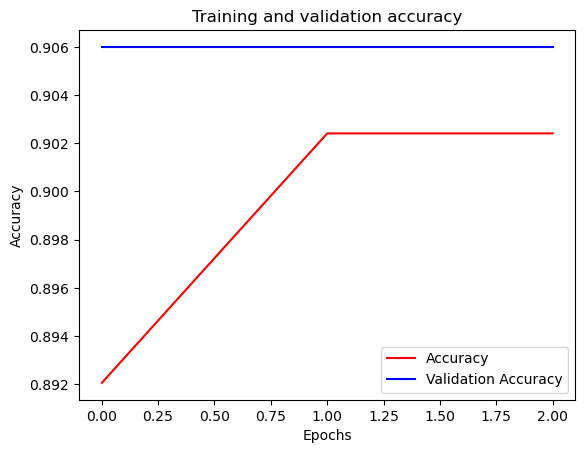

<Figure size 640x480 with 0 Axes>

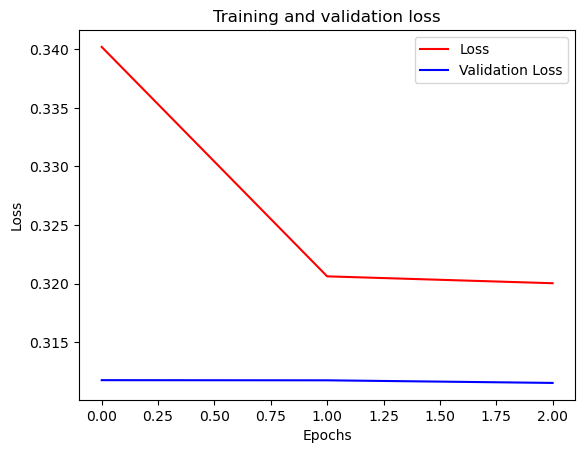

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

In [ ]:
embeddings_index = {};

with open('datasets\glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embeddings_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim = vocab_size,
                                    output_dim = embedding_dim,
                                    input_length = max_length,
                                    weights = [embeddings_matrix],
                                    trainable = False))
model.add(tf.keras.layers.SimpleRNN(64))
model.add(tf.keras.layers.Dense(6, activation = 'sigmoid'))

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1001, 100)         5999300   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                10560     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6009925 (22.93 MB)
Trainable params: 10625 (41.50 KB)
Non-trainable params: 5999300 (22.89 MB)
_________________________________________________________________


In [ ]:
history = model.fit(training_padded, training_labels, epochs = num_epochs, batch_size=batch_size, validation_data=(testing_padded, testing_labels))

print("Training Complete")

Epoch 1/3
77/77 [==============================] - 24s 292ms/step - loss: 0.4248 - accuracy: 0.8516 - val_loss: 0.3089 - val_accuracy: 0.9080
Epoch 2/3
77/77 [==============================] - 24s 317ms/step - loss: 0.3198 - accuracy: 0.9022 - val_loss: 0.3083 - val_accuracy: 0.9080
Epoch 3/3
77/77 [==============================] - 21s 273ms/step - loss: 0.3208 - accuracy: 0.9021 - val_loss: 0.3071 - val_accuracy: 0.9080
Training Complete


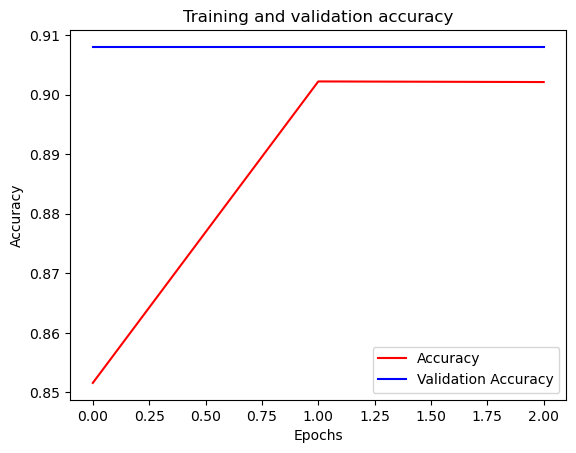

<Figure size 640x480 with 0 Axes>

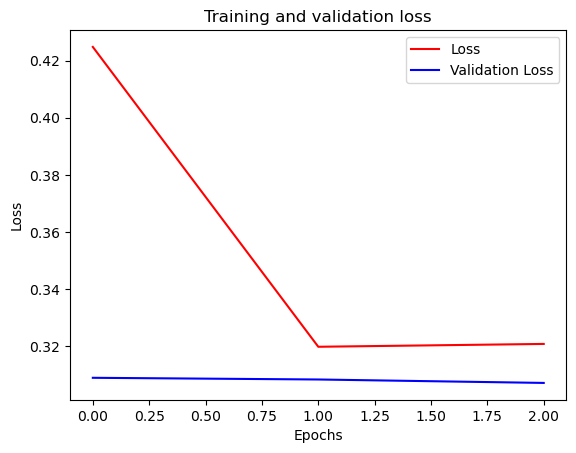

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()